In [2]:
###########################################################################################
# CTRL F for QUESTION to see the problematic parts
###########################################################################################
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
import os
import tensorflow as tf
from keras.models import Sequential, Model 
from keras.layers import *
import keras.backend as k
import keras.utils
from keras import optimizers as opt
from sklearn.model_selection import train_test_split

print(k.image_dim_ordering())

k.set_image_dim_ordering('th')

#tf.keras

gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


tf


In [3]:
#These paths are specific to my computer
#change them to match where you store your nrrds and segs
rootPath = "E:\\Patient Data Summer\\NN\\"
nrrdPath = "E:\\Patient Data Summer\\NN\\Nrrds\\"
segPath = "E:\\Patient Data Summer\\NN\\Segs\\"

nrrdFilePaths = []
nrrdFileNames = []
normalizedFilePaths = []
normalizedFileNames = []

labelFilePaths = []

#mainly unused, i could probably remove this
def loadNpy(name):
    b = np.load(name)
    return b

def bnormalize(arr):
    arrAbsolute = np.fabs(arr)
    arrMax = np.amax(arrAbsolute)
    print(arrAbsolute)
    print(arrMax)
    if arrMax != 0:
        arr = np.divide(arrAbsolute,arrMax)
        print("divided")
    else:
        print("error, max value is zero")
    return arr

for root, dirs, files in os.walk(nrrdPath):
        for filename in files:
            if filename.endswith("normalized.npy") or filename.endswith("5dim.npy"):
                continue
            elif filename.endswith(".npy"):
                path=os.path.join(root,filename)
                print(path)
                a = loadNpy(path)
                nrrdFilePaths.append(path)
                #very messy, but is necessary to weed out the normalized images
                if filename.endswith("normalized.npy") or filename.endswith("5dim.npy"):
                    continue
                elif filename.endswith(".npy"):
                    noExtension = filename[:-4]
                    nrrdFileNames.append(noExtension)
                    normalizedFileNames.append(noExtension)
                    newExtension = noExtension + '_normalized.npy'
                    outPutFileName = os.path.join(root,newExtension)
                    normalizedFilePaths.append(outPutFileName)
                

print(nrrdFilePaths)
print(normalizedFilePaths)
print(nrrdFileNames)

E:\Patient Data Summer\NN\Nrrds\PTMW0075_Prone.npy
E:\Patient Data Summer\NN\Nrrds\PTMW0075_Supine.npy
E:\Patient Data Summer\NN\Nrrds\PTOC0078_Prone.npy
E:\Patient Data Summer\NN\Nrrds\PTOC0078_Supine.npy
E:\Patient Data Summer\NN\Nrrds\PTOD0072_Prone.npy
E:\Patient Data Summer\NN\Nrrds\PTOD0072_Supine.npy
E:\Patient Data Summer\NN\Nrrds\PTPD0028_Prone.npy
E:\Patient Data Summer\NN\Nrrds\PTPD0028_Supine.npy
E:\Patient Data Summer\NN\Nrrds\PTPP0051_Prone.npy
E:\Patient Data Summer\NN\Nrrds\PTPP0051_Supine.npy
E:\Patient Data Summer\NN\Nrrds\PTPR0077_Prone.npy
E:\Patient Data Summer\NN\Nrrds\PTPR0077_Supine.npy
['E:\\Patient Data Summer\\NN\\Nrrds\\PTMW0075_Prone.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTMW0075_Supine.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOC0078_Prone.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOC0078_Supine.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOD0072_Prone.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOD0072_Supine.npy', 'E:\\Patient Data Summer\\NN\\

In [4]:
#get labels
#I dont normalize these because they are based on binary label maps
downsizedLabelFilePaths=[]
labelFilePaths=[]
for root, dirs, files in os.walk(segPath):
        for filename in files:
            if filename.endswith("Label.npy"):                
                noExtension = filename[:-4]
                newExtension = noExtension + '_downsized.npy'
                outPutFileName = os.path.join(root,newExtension)
                downsizedLabelFilePaths.append(outPutFileName)
                
                path=os.path.join(root,filename)
                labelFilePaths.append(path)
print(downsizedLabelFilePaths)

['E:\\Patient Data Summer\\NN\\Segs\\PTMW0075_ProSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTMW0075_SupSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOC0078_ProSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOC0078_SupSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOD0072_ProSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOD0072_SupSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPD0028_ProSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPD0028_SupSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPP0051_ProSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPP0051_SupSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPR0077_ProSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPR0077_SupSegLabel_downsized.npy']


In [5]:
#downsize CTs
zResize = []
from scipy.ndimage import zoom
nnnn=0
for i in nrrdFilePaths:
    print(i)
    a = loadNpy(i)
    a = zoom(a, (0.25,0.25,0.25))
    b=a.shape
    c=(b[0])
    d=128/c
    zResize.append(d)
    a=zoom(a, (d,1,1))
    print(a.shape)
    np.save(normalizedFilePaths[nnnn],a)
    nnnn+=1

E:\Patient Data Summer\NN\Nrrds\PTMW0075_Prone.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTMW0075_Supine.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTOC0078_Prone.npy


C:\Users\PerkLab\Anaconda3\envs\DL1\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTOC0078_Supine.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTOD0072_Prone.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTOD0072_Supine.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPD0028_Prone.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPD0028_Supine.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPP0051_Prone.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPP0051_Supine.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPR0077_Prone.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPR0077_Supine.npy
(128, 128, 128)


In [6]:
#downsize labels
nnnnn=0
for i in labelFilePaths:
    print(i)
    a = loadNpy(i)
    print(a.shape)
    a = zoom(a, (0.25,0.25,0.25))
    print(a.shape)
    b=a.shape
    c=(b[0])
    d=128/c
    print(d)
    zResize.append(d)
    a=zoom(a, (d,1,1))
    print(a.shape)
    np.save(downsizedLabelFilePaths[nnnnn],a)
    nnnnn+=1
    print(a)

E:\Patient Data Summer\NN\Segs\PTMW0075_ProSegLabel.npy
(652, 512, 512)
(163, 128, 128)
0.7852760736196319
(128, 128, 128)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
E:\Patient Data Summer\NN\Segs\PTMW0075_SupSegLabel.npy
(578, 512, 512)
(144, 128, 128)
0.8888888888888

(713, 512, 512)
(178, 128, 128)
0.7191011235955056
(128, 128, 128)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
E:\Patient Data Summer\NN\Segs\PTPR0077_SupSegLabel.npy
(621, 512, 512)
(155, 128, 128)
0.8258064516129032
(128, 128, 128)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0

In [7]:
#create the normalized images
n=0
for i in normalizedFilePaths:
    print(i)
    a = loadNpy(i)
    b = bnormalize(a)
    np.save(normalizedFilePaths[n],b)
    n+=1
print(normalizedFilePaths)

E:\Patient Data Summer\NN\Nrrds\PTMW0075_Prone_normalized.npy
[[[2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  ...
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]]

 [[2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  ...
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]]

 [[2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  ...
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]]

 ...

 [[2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 204

E:\Patient Data Summer\NN\Nrrds\PTOD0072_Supine_normalized.npy
[[[2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  ...
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]]

 [[2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  ...
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]]

 [[2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  ...
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]]

 ...

 [[1982. 1982. 1982. ... 1982. 1982. 1982.]
  [1982. 1982. 1982. ... 1982. 1982. 1982.]
  [1982. 1982. 1982. ... 19

E:\Patient Data Summer\NN\Nrrds\PTPR0077_Prone_normalized.npy
[[[2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  ...
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]]

 [[2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  ...
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]]

 [[2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  ...
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]]

 ...

 [[2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 2048. 2048. 2048.]
  [2048. 2048. 2048. ... 204

In [8]:
print(labelFilePaths)

['E:\\Patient Data Summer\\NN\\Segs\\PTMW0075_ProSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTMW0075_SupSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOC0078_ProSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOC0078_SupSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOD0072_ProSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOD0072_SupSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPD0028_ProSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPD0028_SupSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPP0051_ProSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPP0051_SupSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPR0077_ProSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPR0077_SupSegLabel.npy']


In [9]:
#mostly borrowed from an article online
#i probably wont use this in the final version, this is mainly a placeholder for testing
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = k.flatten(y_true)
    y_pred_f = k.flatten(y_pred)
    intersection = k.sum(y_true_f * y_pred_f)
    
    return (2 * intersection + smooth) / (k.sum(y_true_f) + k.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    
    return -dice_coef(y_true, y_pred)

In [10]:
image5Dim = []
image5DimPaths = []
for yyy in normalizedFilePaths:
    print(yyy)
    a=np.load(yyy)
    a=a[np.newaxis,...]
    yyy = yyy[:-4]
    yyy=yyy + '_5dim.npy'
    np.save(yyy,a)
    print(np.shape(a))
    image5Dim.append(a)
    image5DimPaths.append(yyy)
    
print(np.shape(image5Dim))

E:\Patient Data Summer\NN\Nrrds\PTMW0075_Prone_normalized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTMW0075_Supine_normalized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTOC0078_Prone_normalized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTOC0078_Supine_normalized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTOD0072_Prone_normalized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTOD0072_Supine_normalized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPD0028_Prone_normalized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPD0028_Supine_normalized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPP0051_Prone_normalized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPP0051_Supine_normalized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPR0077_Prone_normalized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPR0077_Supine_normalized.npy
(1, 128, 128, 128)
(12, 1, 128, 128, 128)

In [11]:
label5Dim = []
label5DimPaths = []

for iiiii in downsizedLabelFilePaths:
    print(iiiii)
    a=np.load(iiiii)
    a=a[np.newaxis,...]
    iiiii = iiiii[:-4]
    iiiii=iiiii + '_5dim.npy'
    np.save(iiiii,a)
    print(np.shape(a))
    label5Dim.append(a)
    label5DimPaths.append(yyy)
    
print(np.shape(label5Dim))

E:\Patient Data Summer\NN\Segs\PTMW0075_ProSegLabel_downsized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTMW0075_SupSegLabel_downsized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTOC0078_ProSegLabel_downsized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTOC0078_SupSegLabel_downsized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTOD0072_ProSegLabel_downsized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTOD0072_SupSegLabel_downsized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTPD0028_ProSegLabel_downsized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTPD0028_SupSegLabel_downsized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTPP0051_ProSegLabel_downsized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTPP0051_SupSegLabel_downsized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTPR0077_ProSegLabel_downsized.npy
(1, 128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTPR0077_SupSegLabel_downsized.npy

In [12]:
#might not be necessary, but creates a list of the actual arrays, not just the paths
nn=0
listOfNormalized=[]
for i in normalizedFilePaths:  
    a=np.load(i)
    listOfNormalized.append(a)
    nn+=1
    print(np.shape(normalizedFilePaths))
print(listOfNormalized)

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
[array([[[0.91674125, 0.91674125, 0.91674125, ..., 0.91674125,
         0.91674125, 0.91674125],
        [0.91674125, 0.91674125, 0.91674125, ..., 0.91674125,
         0.91674125, 0.91674125],
        [0.91674125, 0.91674125, 0.91674125, ..., 0.91674125,
         0.91674125, 0.91674125],
        ...,
        [0.91674125, 0.91674125, 0.91674125, ..., 0.91674125,
         0.91674125, 0.91674125],
        [0.91674125, 0.91674125, 0.91674125, ..., 0.91674125,
         0.91674125, 0.91674125],
        [0.91674125, 0.91674125, 0.91674125, ..., 0.91674125,
         0.91674125, 0.91674125]],

       [[0.91674125, 0.91674125, 0.91674125, ..., 0.91674125,
         0.91674125, 0.91674125],
        [0.91674125, 0.91674125, 0.91674125, ..., 0.91674125,
         0.91674125, 0.91674125],
        [0.91674125, 0.91674125, 0.91674125, ..., 0.91674125,
         0.91674125, 0.91674125],
        ...,
        [0.91674125, 0.91674125, 0.

In [13]:
#same as above but for labels
#please excuse the variable names
nnn=0
listOfLabels=[]
for i in downsizedLabelFilePaths:  
    a=np.load(i)
    listOfLabels.append(a)
    nnn+=1
print(listOfLabels)

[array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ...,

In [14]:
X_train, X_test, y_train, y_test = train_test_split (image5Dim, label5Dim, test_size = 0.10, random_state = 0)


print(X_train)

print(np.shape(X_train))
print(np.shape(y_train))


[array([[[[0.30997428, 0.30997428, 0.30997428, ..., 0.30997428,
          0.30997428, 0.30997428],
         [0.30997428, 0.30997428, 0.30997428, ..., 0.30997428,
          0.30997428, 0.30997428],
         [0.30997428, 0.30997428, 0.30997428, ..., 0.30997428,
          0.30997428, 0.30997428],
         ...,
         [0.30997428, 0.30997428, 0.30997428, ..., 0.30997428,
          0.30997428, 0.30997428],
         [0.30997428, 0.30997428, 0.30997428, ..., 0.30997428,
          0.30997428, 0.30997428],
         [0.30997428, 0.30997428, 0.30997428, ..., 0.30997428,
          0.30997428, 0.30997428]],

        [[0.30997428, 0.30997428, 0.30997428, ..., 0.30997428,
          0.30997428, 0.30997428],
         [0.30997428, 0.30997428, 0.30997428, ..., 0.30997428,
          0.30997428, 0.30997428],
         [0.30997428, 0.30997428, 0.30997428, ..., 0.30997428,
          0.30997428, 0.30997428],
         ...,
         [0.30997428, 0.30997428, 0.30997428, ..., 0.30997428,
          0.30997428, 0.

In [15]:
#plt.imshow(rrrrrrrrrrrrrrr[0,0,50,0])
#plt.imshow(tttttttttttttt[90])

In [16]:
testInput1=np.load(normalizedFilePaths[0])
print(np.shape(testInput1))
testInput1=testInput1[np.newaxis,np.newaxis,...]
print(np.shape(testInput1))

testLabel1=np.load(downsizedLabelFilePaths[0])
print(np.shape(testLabel1))
testLabel1=testLabel1[np.newaxis,np.newaxis,...]

print(testInput1)

print(np.shape(testLabel1))

(128, 128, 128)
(1, 1, 128, 128, 128)
(128, 128, 128)
[[[[[0.91674125 0.91674125 0.91674125 ... 0.91674125 0.91674125
     0.91674125]
    [0.91674125 0.91674125 0.91674125 ... 0.91674125 0.91674125
     0.91674125]
    [0.91674125 0.91674125 0.91674125 ... 0.91674125 0.91674125
     0.91674125]
    ...
    [0.91674125 0.91674125 0.91674125 ... 0.91674125 0.91674125
     0.91674125]
    [0.91674125 0.91674125 0.91674125 ... 0.91674125 0.91674125
     0.91674125]
    [0.91674125 0.91674125 0.91674125 ... 0.91674125 0.91674125
     0.91674125]]

   [[0.91674125 0.91674125 0.91674125 ... 0.91674125 0.91674125
     0.91674125]
    [0.91674125 0.91674125 0.91674125 ... 0.91674125 0.91674125
     0.91674125]
    [0.91674125 0.91674125 0.91674125 ... 0.91674125 0.91674125
     0.91674125]
    ...
    [0.91674125 0.91674125 0.91674125 ... 0.91674125 0.91674125
     0.91674125]
    [0.91674125 0.91674125 0.91674125 ... 0.91674125 0.91674125
     0.91674125]
    [0.91674125 0.91674125 0.91674125

In [17]:
print(np.shape(np.array(X_train)))
print(np.shape(y_train))
print(normalizedFilePaths)

(10, 1, 128, 128, 128)
(10, 1, 128, 128, 128)
['E:\\Patient Data Summer\\NN\\Nrrds\\PTMW0075_Prone_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTMW0075_Supine_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOC0078_Prone_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOC0078_Supine_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOD0072_Prone_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOD0072_Supine_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTPD0028_Prone_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTPD0028_Supine_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTPP0051_Prone_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTPP0051_Supine_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTPR0077_Prone_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTPR0077_Supine_normalized.npy']


In [171]:
NN = Model()
inp = Input((1,128,128,128))
learning_rate_decay = (0.001 - 0.0001) / 50

#contracting path
conv1 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(inp)
conv1 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling3D(pool_size=(2, 2, 2))(drop1)
conv2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling3D(pool_size=(2, 2, 2))(drop2)
conv3 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling3D(pool_size=(2, 2, 2))(drop3)
conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)
conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv5)
print(conv5.shape)

#expansion path
up6 = UpSampling3D((2, 2, 2),data_format='channels_first')(conv5)
print(up6.shape)
up6 = concatenate([up6,drop4],axis=1)
print(up6.shape)
conv6 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up6)
print(conv6.shape)
conv6 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv6)
drop6 = Dropout(0.5)(conv6)

print(conv6.shape)
up7 = UpSampling3D((2, 2, 2),data_format='channels_first')(drop6)
up7 = concatenate([up7,drop3],axis=1)
conv7 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(up7)
conv7 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv7)
drop7 = Dropout(0.5)(conv7)

print(conv7.shape)
up8 = UpSampling3D((2, 2, 2),data_format='channels_first')(drop7)
up8 = concatenate([up8,drop2],axis=1)
conv8 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(up8)
conv8 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv8)
drop8 = Dropout(0.5)(conv8)

print(conv8.shape)
up9 = UpSampling3D((2, 2, 2),data_format='channels_first')(drop8)
up9 = concatenate([up9,drop1],axis=1)
conv9 = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(up9)
conv9 = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(conv9)
drop9 = Dropout(0.5)(conv9)

print(conv9.shape)

conv10 = Conv3D(1, (3,3,3), activation='sigmoid', padding="same")(drop9)
print(conv10.shape)

out = Model(inputs=[inp], outputs=[conv10])

#out.summary()

(?, 128, 8, 8, 8)
(?, 128, 16, 16, 16)
(?, 256, 16, 16, 16)
(?, 32, 16, 16, 16)
(?, 32, 16, 16, 16)
(?, 16, 32, 32, 32)
(?, 16, 64, 64, 64)
(?, 8, 128, 128, 128)
(?, 1, 128, 128, 128)


In [172]:
#out.compile(optimizer=opt.Adam(lr = 1e-4), loss=dice_coef_loss, metrics=[dice_coef])
#model does not work with adam optimizer
out.compile(optimizer=keras.optimizers.SGD(lr = 0.001), loss='binary_crossentropy', metrics=['accuracy'])
print(testInput1.shape)
print(testLabel1.shape)
print(np.shape(X_train))

(1, 1, 128, 128, 128)
(1, 1, 128, 128, 128)
(10, 1, 128, 128, 128)


In [173]:
#TODO graph the loss and accuracy
#TODO tweak epochs, 50 is clearly far too much, maybe try 25?
out.fit(np.array(X_train),np.array(y_train), batch_size=1, epochs=50, verbose=1)
print("fitted!")

Epoch 1/50
10/10 [==============================] - 10s 1s/step - loss: 0.6864 - acc: 0.6847
Epoch 2/50
10/10 [==============================] - 4s 444ms/step - loss: 0.6799 - acc: 0.7929
Epoch 3/50
10/10 [==============================] - 4s 432ms/step - loss: 0.6727 - acc: 0.8571
Epoch 4/50
10/10 [==============================] - 4s 427ms/step - loss: 0.6649 - acc: 0.8984
Epoch 5/50
10/10 [==============================] - 4s 430ms/step - loss: 0.6565 - acc: 0.9261
Epoch 6/50
10/10 [==============================] - 4s 433ms/step - loss: 0.6475 - acc: 0.9458
Epoch 7/50
10/10 [==============================] - 4s 434ms/step - loss: 0.6378 - acc: 0.9601
Epoch 8/50
10/10 [==============================] - 4s 435ms/step - loss: 0.6275 - acc: 0.9687
Epoch 9/50
10/10 [==============================] - 4s 438ms/step - loss: 0.6163 - acc: 0.9743
Epoch 10/50
10/10 [==============================] - 4s 437ms/step - loss: 0.6042 - acc: 0.9778
Epoch 11/50
10/10 [==============================] 

In [174]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

#TODO make a path for this automatically
name = "model_" + timestamp + ".h5"
modelPath = os.path.join("E:\\Patient Data Summer\\NN\\Output\\", name)
out.save(modelPath)

In [184]:
#score = out.evaluate(np.array(X_test), np.array(y_test), batch_size=1)
outputSeg=out.predict(np.array(X_test))
outputSeg2=out.predict(np.array(y_test))
print(np.shape(outputSeg))
print(type(outputSeg))
print(score)
print(outputSeg)

(2, 1, 128, 128, 128)
<class 'numpy.ndarray'>
[0.626509428024292, 0.9859297275543213]
[[[[[0.37271643 0.2992059  0.26858968 ... 0.27209067 0.29820228
     0.35903966]
    [0.3415931  0.23564985 0.19679794 ... 0.19837862 0.22940314
     0.30018133]
    [0.32205522 0.20735705 0.16666564 ... 0.16973257 0.20633951
     0.2820628 ]
    ...
    [0.32073683 0.21009043 0.17100674 ... 0.17422509 0.211654
     0.28662756]
    [0.34217495 0.24879247 0.21296403 ... 0.214638   0.24949598
     0.31276107]
    [0.40776598 0.34660646 0.32613552 ... 0.3261242  0.34758842
     0.3840714 ]]

   [[0.3342927  0.25265157 0.21266744 ... 0.21176335 0.24430415
     0.3184384 ]
    [0.28368983 0.16230154 0.11938128 ... 0.11864829 0.14996463
     0.23454535]
    [0.25218442 0.12485331 0.08552307 ... 0.08694777 0.1197601
     0.20568404]
    ...
    [0.25009638 0.12405267 0.08575705 ... 0.08782887 0.12196791
     0.20893258]
    [0.27916145 0.15895739 0.1189321  ... 0.11982688 0.15599206
     0.237284  ]
    [0.3

In [228]:
#absOutputSeg = np.fabs(outputSeg)

#print(np.aMax(absOutputSeg))
#print(np.aMin(absOutputSeg))

normOutputSeg = bnormalize(outputSeg)

#TODO
#automatically determine the divisor for thresholding
#this is the only non-automatic part
binaryOutputSeg = (outputSeg2 < 0.005).astype(np.uint8)
print(binaryOutputSeg)
print(np.shape(binaryOutputSeg))

[[[[[0.37271643 0.2992059  0.26858968 ... 0.27209067 0.29820228
     0.35903966]
    [0.3415931  0.23564985 0.19679794 ... 0.19837862 0.22940314
     0.30018133]
    [0.32205522 0.20735705 0.16666564 ... 0.16973257 0.20633951
     0.2820628 ]
    ...
    [0.32073683 0.21009043 0.17100674 ... 0.17422509 0.211654
     0.28662756]
    [0.34217495 0.24879247 0.21296403 ... 0.214638   0.24949598
     0.31276107]
    [0.40776598 0.34660646 0.32613552 ... 0.3261242  0.34758842
     0.3840714 ]]

   [[0.3342927  0.25265157 0.21266744 ... 0.21176335 0.24430415
     0.3184384 ]
    [0.28368983 0.16230154 0.11938128 ... 0.11864829 0.14996463
     0.23454535]
    [0.25218442 0.12485331 0.08552307 ... 0.08694777 0.1197601
     0.20568404]
    ...
    [0.25009638 0.12405267 0.08575705 ... 0.08782887 0.12196791
     0.20893258]
    [0.27916145 0.15895739 0.1189321  ... 0.11982688 0.15599206
     0.237284  ]
    [0.35279584 0.25892955 0.22757682 ... 0.22910595 0.26062053
     0.327529  ]]

   [[0.3194

In [230]:
from mpl_toolkits import mplot3d

timestamp2 = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
ppath = os.path.join("E:\\Patient Data Summer\\NN\\Output\\", timestamp2 + ".npy")
np.save(ppath,binaryOutputSeg)

(2, 1, 128, 128, 128)


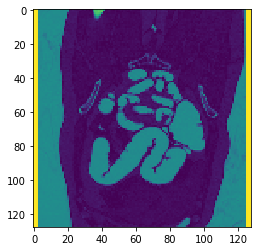

In [231]:
#original CT
lastNrrd=np.array(X_test)
print(np.shape(lastNrrd))
plt.imshow(lastNrrd[0,0,:,80,:])

(2, 1, 128, 128, 128)


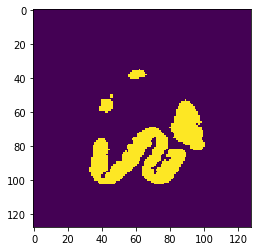

In [232]:
#human segmentation
lastSeg=np.array(y_test)
print(np.shape(lastSeg))
plt.imshow(lastSeg[0,0,:,80,:])

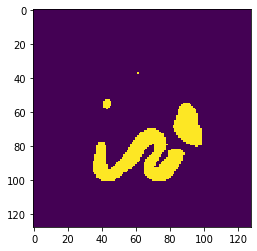

In [233]:
#Neural network segmentation converted to binary
plt.imshow(np.array(binaryOutputSeg[0,0,:,80,:]))

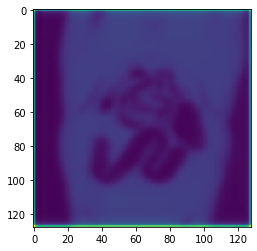

In [234]:
# output from running NN on X_test

plt.imshow(np.array(outputSeg[0,0,:,80,:]))

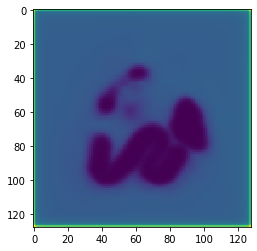

In [235]:
# output from running NN on y_test
#aka output segmentation before binarization
plt.imshow(np.array(outputSeg2[0,0,:,80,:]))